## Assignment - Syntactic Analysis

### Table of Contents

1. Problem Statement 
2. Data Preparation
3. Build the vanilla Viterbi based POS tagger
4. Technique 1 to handle unknown words
5. Technique 2 to handle unkown words and improve accuracy
6. Model Evaluation
7. Summary


### 1. Problem Statement

In this assignment, we need to modify the Viterbi algorithm to solve the problem of unknown words using at least two techniques.

##### Here are the High level steps we need to acomplish.

1. Write the vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words) 
2.  Solve the problem of unknown words using at least two techniques. 
3.  Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.
4.  List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications


### 2. Data Preparation

* Import required libraries
* For this assignment, we will use the Treebank dataset of NLTK with the 'universal' tagset. The Universal tagset of NLTK comprises only 12 coarse tag classes.
* Split data into 95:5 ratio for train and test.
* Data analysis like no.of train set, types of tag set, frequent tag sets.
* create functions to calculate Emission probability and Transition probability.

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize


In [2]:
# reading the Treebank tagged 'universal' sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# first few tagged sentences
print(len(nltk_data))  #no of tagged sentences
print(nltk_data[:3])

#We have around 3914 sentences from the dataset.

3914
[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'

In [4]:
# Splitting into train and test into 95:5 ratio. 
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set)) 

#Data is split into 95:5 ratio. Keeping the validation set small to restrict the runtime.

3718
196


In [5]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

#We have 95K words in train set.

95790

In [6]:
# Which is the most frequent tag in the corpus
from collections import Counter

tags = [pair[1] for pair in train_tagged_words]
tag_counts = Counter(tags)
tag_counts.most_common()

# Noun is the most common POS tag followed by VERB and then by '.'
# There are 12 unique POS tags in the data set.

[('NOUN', 27434),
 ('VERB', 12901),
 ('.', 11143),
 ('ADP', 9355),
 ('DET', 8333),
 ('X', 6307),
 ('ADJ', 6098),
 ('NUM', 3372),
 ('PRT', 3067),
 ('ADV', 3022),
 ('PRON', 2586),
 ('CONJ', 2172)]

In [7]:
# Which word is most commonly assigned to the tag '.'
p_tags = [pair for pair in train_tagged_words if pair[1].lower() == '.']
p_counts = Counter(p_tags)
p_counts.most_common()[:10]

#Punctuation marks and character groups used in to delimit linguistic units is tagged to '.'

[((',', '.'), 4650),
 (('.', '.'), 3636),
 (('$', '.'), 671),
 (('``', '.'), 671),
 (("''", '.'), 653),
 (('--', '.'), 222),
 ((';', '.'), 158),
 ((':', '.'), 137),
 (('-RRB-', '.'), 110),
 (('-LRB-', '.'), 104)]

In [8]:
# Which word is most commonly assigned to the tag '.'
x_tags = [pair for pair in train_tagged_words if pair[1] == 'X']
x_counts = Counter(x_tags)
x_counts.most_common()[:10]

# The tag X is used for words that for some reason cannot be assigned to a real part-of-speech category.
# Words containg patterns with '*' symbols in it.
# Numerical 0 is also tagged to X instead of Num.

[(('*-1', 'X'), 1067),
 (('0', 'X'), 1047),
 (('*', 'X'), 916),
 (('*T*-1', 'X'), 777),
 (('*U*', 'X'), 696),
 (('*-2', 'X'), 354),
 (('*T*-2', 'X'), 334),
 (('*-3', 'X'), 127),
 (('*T*-3', 'X'), 92),
 (('*ICH*-1', 'X'), 68)]

In [9]:
# Get all unique word vocabulary from the data set. Also called as tokens 

tokens = [pair[0] for pair in train_tagged_words]
train_vocabulary_set = set(tokens)
print(len(train_vocabulary_set))

#There are around 12k unique Vocabulary in train set.

12063


In [10]:
# Get all unique POS tags from the data set. 
tag_set = sorted(set([pair[1] for pair in train_tagged_words]))
print(len(tag_set))
print(tag_set)

#There are 12 tag sets in the tagged word set. This will be used for our training.

12
['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']


In [11]:
# computing P(w/t) and storing in T x V matrix

t = len(tag_set)
v = len(train_vocabulary_set)
w_given_t = np.zeros((t, v))

In [12]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

#Heatmap 
def plotheatmap(df,Title,Figsize=None):
    
    f,ax= plt.subplots(1,1,figsize=Figsize)   
    sns.heatmap(df,annot=True)
    ax.set_title(Title)
    
    #Fix 3.11 matplot version issue by setting the limits manually.
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
    
    plt.show()

In [13]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(tag_set), len(tag_set)), dtype='float32')
for i, t1 in enumerate(list(tag_set)):
    for j, t2 in enumerate(list(tag_set)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [14]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(tag_set), index=list(tag_set))

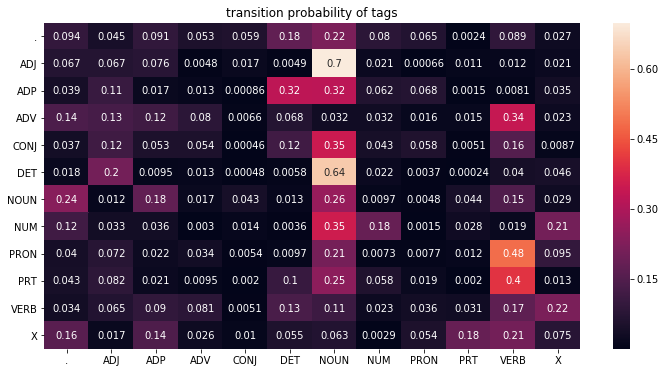

In [15]:
plotheatmap(tags_df,"transition probability of tags",Figsize=(12, 6))

#Adjective followed by a Noun has highest probability of 0.7.
#Determiners followed by Noun comes next with 0.64 probability.
#Verbs are precided by either Pronouns or Particles or Adverbs with a probability of 0.48, 0.4 and 0.34 respectively.

In [16]:
#Transition probability, given previous tag is start of the sentence.
tags_df.loc['.',:]

# Words starting with Noun is highest with 0.22 
# Determiners also has high probability of 0.17 to start the sentence.

.       0.093512
ADJ     0.044961
ADP     0.090819
ADV     0.053038
CONJ    0.059140
DET     0.175446
NOUN    0.218972
NUM     0.079781
PRON    0.065422
PRT     0.002423
VERB    0.088935
X       0.027461
Name: ., dtype: float32

### 3. Build the vanilla Viterbi based POS tagger

Vanilla Viterbi algorithm works as follows:

* For each word, we compute the P(tag|word) for each tag in the tag set and then assign the tag having the max P(tag/word).

* P(tag|word)  = (emission probability of the word-tag pair) * (transition probability from the previous tag).

In [17]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(100)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
#test_run
rndom

[38, 118, 117, 45, 181]

In [18]:
#rndom = [random.randint(1,len(test_set)) for x in range(5)]
#rndom

#[9, 172, 178, 22, 26]
#[91, 61, 5, 8, 5]
#[113, 30, 2, 24, 150]   - 98.3
#[88, 68, 15, 149, 106]  - 91.6
#[38, 118, 117, 45, 181] - 88.24, 89.8
#[104, 98, 52, 154, 46] - 96
#[14, 69, 23, 105, 69]  - 88.6 -123


In [28]:
# Viterbi Heuristic
def Viterbi_Vanilla(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            #Print for each word
            print(word,tag,key,emission_p,transition_p,state_probability)
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


In [20]:
#Function to check accuracy
def check_accuracy(tagged_set, test_run_base,msg):
    check = [i for i, j in zip(tagged_set, test_run_base) if i == j] 
    accuracy = round((len(check)/len(tagged_set))*100,2)
    print(msg,accuracy,end='%')

# Function to check incorrect tag cases.     
def check_diff(tagged_set,test_run_base):
    incorrect_tagged_cases = [[test_run_base[i-1],j[0],j[1],test_run_base[i+1]] for i, j in enumerate(zip(tagged_set, test_run_base)) if j[0]!=j[1]]
    diff_df = pd.DataFrame(incorrect_tagged_cases, columns = ['Previous Word-Tag','Predicted Word-Tag','Actual Word-Tag','Next Word-Tag'])
    return diff_df
    

In [21]:
#Test on Vanilla Viterbi model
start = time.time()
tagged_set1 = Viterbi_Vanilla(test_tagged_words)
end = time.time()
print("Time taken in seconds: ", round(end-start,2))

check_accuracy(tagged_set1,test_run_base,'Accuracy of Viterbi Vanilla model: ')

check_diff(tagged_set1,test_run_base)

Time taken in seconds:  48.7
Accuracy of Viterbi Vanilla model:  92.31%

,Previous Word-Tag,Predicted Word-Tag,Actual Word-Tag,Next Word-Tag
0,"(U.S., NOUN)","(tariff, VERB)","(tariff, NOUN)","(classifications, NOUN)"
1,"(tariff, NOUN)","(classifications, VERB)","(classifications, NOUN)","(., .)"
2,"(third, ADJ)","(stock-manipulation, VERB)","(stock-manipulation, ADJ)","(trial, NOUN)"
3,"(Manhattan, NOUN)","(courtroom, VERB)","(courtroom, NOUN)","(of, ADP)"
4,"(Johnson, NOUN)","(Lowe, VERB)","(Lowe, NOUN)","(., .)"
5,"(,, .)","(adverse, VERB)","(adverse, ADJ)","(or, CONJ)"
6,"(or, CONJ)","(otherwise, VERB)","(otherwise, ADV)","(,, .)"
7,"(so-called, ADJ)","(Team, VERB)","(Team, NOUN)","(Taurus, NOUN)"
8,"(the, DET)","(involvement, VERB)","(involvement, NOUN)","(of, ADP)"
9,"(,, .)","(assembly-line, VERB)","(assembly-line, NOUN)","(workers, NOUN)"


#### Observations from Vanilla Viterbi Model

* Most of the unknown words are tagged as '.' since its the first tag
* For unknown words Emission probability will be 0 and hence it takes the default flag.
* In order to resolve this we can consider only the transition probability and evaluate the accuracy.
* some numbers are wrongly tagged as well, this can be resolved by assigning it to NUM by default.

### Solve the problem of unknown words

In [101]:
# list all unknown words in test set compared to train set.

test_tagged_set = set([t for t in test_tagged_words])
train_tagged_set = set([t for t in train_tagged_words])

unknown_words = list(test_tagged_set - train_tagged_set)
print("Total Unknown words :", len(unknown_words))
print("\n")
print("Unknown Words :", unknown_words)

Total Unknown words : 80


Unknown Words : ['noted', 'executive', 'that', 'trading', 'of', 'job', 'remaining', 'in', 'specialist', 'sell', 'justices', 'Bendectin', 'sales', 'can', 'Chrysler', 'there', 'it', 'floor', 'crookery', 'market', 'go', '``', 'says', 'day', 'fear', 'already', ',', 'scams', 'and', 'been', 'to', '*T*-3', ':', 'be', 'programs', 'the', 'found', 'off', 'forced', 'Big', 'years', 'order', 'one', '0', 'marketing', 'only', 'first', 'for', '*-2', 'hit', 'When', '*-1', 'Board', "''", 'printers', '*T*-1', 'litigation', 'None', 'California', '.', 'drug', 'start', 'He', 'haul', 'with', 'had', 'show', 'Auditors', 'a', 'long', 'hear', 'ingenuity', 'U.S.', 'The', 'anti-morning-sickness', 'appears', '20', 'on', 'much', 'you']


In [23]:
test_tagged_words

['Timex',
 'had',
 'requested',
 'duty-free',
 'treatment',
 'for',
 'many',
 'types',
 'of',
 'watches',
 ',',
 'covered',
 '*',
 'by',
 '58',
 'different',
 'U.S.',
 'tariff',
 'classifications',
 '.',
 'Attorneys',
 'in',
 'the',
 'third',
 'stock-manipulation',
 'trial',
 'of',
 'GAF',
 'Corp.',
 'began',
 'opening',
 'arguments',
 'yesterday',
 'in',
 'the',
 'Manhattan',
 'courtroom',
 'of',
 'U.S.',
 'District',
 'Judge',
 'Mary',
 'Johnson',
 'Lowe',
 '.',
 'The',
 'company',
 'said',
 '0',
 'the',
 'restructuring',
 'is',
 "n't",
 'expected',
 '*-1',
 'to',
 'have',
 'any',
 'impact',
 ',',
 'adverse',
 'or',
 'otherwise',
 ',',
 'on',
 'its',
 'financial',
 'results',
 '.',
 'The',
 'FTC',
 'budget',
 'request',
 'of',
 '$',
 '70',
 'million',
 '*U*',
 ',',
 'about',
 '$',
 '34',
 'million',
 '*U*',
 'of',
 'which',
 '*T*-1',
 'would',
 'go',
 'for',
 'antitrust',
 'enforcement',
 ',',
 'would',
 'also',
 'be',
 'cut',
 '*-85',
 'by',
 '$',
 '15',
 'million',
 '*U*',
 '.',
 '

In [29]:
small_set=['different',
 'U.S.',
 'tariff',
 'classifications',]

small_set_result = Viterbi_Vanilla(small_set)
#print(word,tag,emission_p,transition_p,state_probability)
            

different VERB 0 0.0 0.08893476 0.0
different ADV 0 0.0 0.05303778 0.0
different NUM 0 0.0 0.079781026 0.0
different ADP 0 0.0 0.09081935 0.0
different PRT 0 0.0 0.002423046 0.0
different ADJ 0 0.0029517874713020664 0.04496096 0.00013271520062719028
different X 0 0.0 0.027461186 0.0
different NOUN 0 0.0 0.21897155 0.0
different DET 0 0.0 0.17544647 0.0
different . 0 0.0 0.09351162 0.0
different PRON 0 0.0 0.06542224 0.0
different CONJ 0 0.0 0.05914027 0.0
U.S. VERB 1 0.0 0.011643162 0.0
U.S. ADV 1 0.0 0.0047556576 0.0
U.S. NUM 1 0.0 0.0208265 0.0
U.S. ADP 1 0.0 0.0764185 0.0
U.S. PRT 1 0.0 0.010823221 0.0
U.S. ADJ 1 0.00016398819285011479 0.066743195 1.0945095942426251e-05
U.S. X 1 0.0 0.021154476 0.0
U.S. NOUN 1 0.007581832762265802 0.6985897 0.005296590142758637
U.S. DET 1 0.0 0.004919646 0.0
U.S. . 1 0.0 0.06657921 0.0
U.S. PRON 1 0.0 0.0006559528 0.0
U.S. CONJ 1 0.0 0.016890785 0.0
tariff VERB 2 0.0 0.14708027 0.0
tariff ADV 2 0.0 0.01724138 0.0
tariff NUM 2 0.0 0.0097324485 0.0
ta

In [31]:
tags_df.loc['ADJ', '']

0.04496096

### Viterbi Modification-Technique I

* For unknow words consider only Transition probability.
* For words containing only numbers tag it to NUM by default.


In [102]:
# Modification of Viterbi Heuristic algorithm to include 
def Viterbi_m1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        num_word=re.search('^[0-9]*.?[0-9]*[0-9]$',word)
        
        if num_word and word not in train_vocabulary_set:
            state.append('NUM')
        else:
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
                # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
                # modification to the original vanilla viterbi algorithm 
                # If word in unknown then consider only the transition_p 
            
                if word not in train_vocabulary_set:
                
                    state_probability = transition_p
                else:
                    state_probability = emission_p * transition_p
            
            
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))


In [116]:
#Test on modified Viterbi model
start = time.time()
tagged_set2 = Viterbi_m1(test_tagged_words)
end = time.time()
print("Time taken in seconds: ", round(end-start,2))

check_accuracy(tagged_set2,test_run_base,'Accuracy of Modified Viterbi Model 1: ')

check_diff(tagged_set2,test_run_base)

Time taken in seconds:  17.59
Accuracy of Modified Viterbi Model 1:  92.23%

,Previous Word-Tag,Predicted Word-Tag,Actual Word-Tag,Next Word-Tag
0,"(scams, NOUN)","(show, NOUN)","(show, VERB)","(much, ADJ)"
1,"(show, VERB)","(much, ADV)","(much, ADJ)","(ingenuity, NOUN)"
2,"(much, ADJ)","(ingenuity, VERB)","(ingenuity, NOUN)","(:, .)"
3,"(found, VERB)","(crookery, X)","(crookery, NOUN)","(the, DET)"
4,"(the, DET)","(sell, VERB)","(sell, NOUN)","(programs, NOUN)"
5,"(specialist, NOUN)","(there, DET)","(there, ADV)","(., .)"
6,"(the, DET)","(only, ADV)","(only, ADJ)","(remaining, VERB)"
7,"(remaining, VERB)","(anti-morning-sickness, X)","(anti-morning-sickness, ADJ)","(drug, NOUN)"


#### Observations after applying Technique 1
* After modifying vanilla Viterbi to consider only Transition probaility for unknown words, Words are not tagged to Default tags now.
* Accuracy has improved significantly from 88% to 92.3%. 
* Several Adjectives are incorrectly getting tagged as Noun or ADJ.
* Since Viterbi Model is Greedy approach, it goes with max probability eventhough other combinations are valid.Hence, some words might be wrongly tagged.
* Also, Viterbu model do not look ahead and just considers previous tag. Hence some tag which are Noun like 'Sell' in this example gets tagged as Verb. To solve this prolem we can look in to previous 2 tags or even Symantic processing.


### Viterbi Modification-Technique 2


In [177]:
patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- kinderganteners, autobioghapgers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN')
    ]

    

In [178]:

regex_tagger = nltk.RegexpTagger(patterns)

unigram_tagger = nltk.UnigramTagger(train_set, backoff = regex_tagger)

bigram_tagger = nltk.BigramTagger(train_set, backoff = unigram_tagger)

trigram_tagger = nltk.TrigramTagger(train_set, backoff = bigram_tagger)

In [185]:
trigram_tagger.tag_sents([[('scams')]])

[[('scams', 'NOUN')]]

In [182]:
# Modification of Viterbi Heuristic algorithm to include 
def Viterbi_m2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    #unigram_tagger1 = nltk.UnigramTagger(train_set)
    #bigram_tagger1 = nltk.BigramTagger(train_set, backoff = unigram_tagger1)
    #trigram_tagger1 = nltk.TrigramTagger(train_set, backoff = bigram_tagger1)
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        num_word=re.search('^[0-9]*.?[0-9]*[0-9]$',word)
        
        if num_word and word not in train_vocabulary_set:
            state.append('NUM')
            
        elif word not in train_vocabulary_set:
            
            unknown_word_tag = trigram_tagger.tag_sents([[(word)]])
            print(unknown_word_tag)
            for sent in unknown_word_tag:
                for tup in sent:
                    if tup[1] == None:
                        state.append('NOUN')
                    else:
                        state.append(tup[1])
        
        else:
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
                # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
                # modification to the original vanilla viterbi algorithm 
                # If word in unknown then consider only the transition_p 
            
                if word not in train_vocabulary_set:
                
                    state_probability = transition_p
                else:
                    state_probability = emission_p * transition_p
            
            
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))


In [183]:
#Test on modified Viterbi model
start = time.time()
tagged_set2 = Viterbi_m2(test_tagged_words)
end = time.time()
print("Time taken in seconds: ", round(end-start,2))


[[('scams', 'NOUN')]]
NOUN
[[('ingenuity', 'NOUN')]]
NOUN
[[('Auditors', 'NOUN')]]
NOUN
[[('crookery', 'NOUN')]]
NOUN
[[('printers', 'NOUN')]]
NOUN
[[('anti-morning-sickness', 'NOUN')]]
NOUN
[[('Bendectin', 'NOUN')]]
NOUN
Time taken in seconds:  15.65


In [184]:
check_accuracy(tagged_set2,test_run_base,'Accuracy of Modified Viterbi Model 2: ')

check_diff(tagged_set2,test_run_base)

Accuracy of Modified Viterbi Model 2:  94.17%

,Previous Word-Tag,Predicted Word-Tag,Actual Word-Tag,Next Word-Tag
0,"(scams, NOUN)","(show, NOUN)","(show, VERB)","(much, ADJ)"
1,"(show, VERB)","(much, ADV)","(much, ADJ)","(ingenuity, NOUN)"
2,"(the, DET)","(sell, VERB)","(sell, NOUN)","(programs, NOUN)"
3,"(specialist, NOUN)","(there, DET)","(there, ADV)","(., .)"
4,"(the, DET)","(only, ADV)","(only, ADJ)","(remaining, VERB)"
5,"(remaining, VERB)","(anti-morning-sickness, NOUN)","(anti-morning-sickness, ADJ)","(drug, NOUN)"


In [37]:
# Unigram Tagger

unigram_tagger = nltk.UnigramTagger(train_set)
unigram_tagger_accuracy = unigram_tagger.evaluate(test_set)
print("The accuracy of the Unigram Tagger is -", unigram_tagger_accuracy)

The accuracy of the Unigram Tagger is - 0.8998622860515444


In [ ]:
# patterns for tagging using a rule based regex tagger -

patterns = [
    (r'^[aA-zZ].*[0-9]+','NOUN'),  # Alpha Numeric
    (r'.*ness$', 'NOUN'),          
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*', 'NOUN'),    
    (r'.*ly$', 'ADV'),
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'), # modals
    (r'(The|the|A|a|An|an)$', 'DET'),
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), # adjective like 100-megabytes 237-Seats
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb
    (r'[0-9].?[,\/]?[0-9]*','NUM')# Numbers 
    ]

In [38]:
# rule based RegexpTagger

rule_based_tagger = nltk.RegexpTagger(patterns)

# unigram tagger backed up by the rule-based tagger
rule_based_unigram_tagger = nltk.UnigramTagger(train_set, backoff = rule_based_tagger)

accuracy_rule_based_unigram_tagger = rule_based_unigram_tagger.evaluate(test_set)

print("The accuracy of the Unigram Tagger backed up by the RegexpTagger is -", accuracy_rule_based_unigram_tagger)

The accuracy of the Unigram Tagger backed up by the RegexpTagger is - 0.908715325595121


In [39]:
# Bigram tagger

bigram_tagger = nltk.BigramTagger(train_set, backoff = rule_based_unigram_tagger)
bigram_tagger.evaluate(test_set)
accuracy_bigram_tagger = bigram_tagger.evaluate(test_set)
print("The accuracy of the Bigram Tagger backed up by the rule_based_unigram_tagger is -", accuracy_bigram_tagger)

The accuracy of the Bigram Tagger backed up by the rule_based_unigram_tagger is - 0.9118630729883926


In [40]:
# trigram tagger

trigram_tagger = nltk.TrigramTagger(train_set, backoff = bigram_tagger)
trigram_tagger.evaluate(test_set)
accuracy_trigram_tagger = trigram_tagger.evaluate(test_set)
print("The accuracy of the Trigram Tagger backed up by the bigram_tagger is -", accuracy_trigram_tagger)

The accuracy of the Trigram Tagger backed up by the bigram_tagger is - 0.9120598072004722


In [41]:
def trigram_tagger(word, train_set = train_set):
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- kinderganteners, autobioghapgers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN')
    ]

    regex_based_tagger = nltk.RegexpTagger(patterns)
    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff = regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

In [45]:
def viterbi_backedup_by_trigram_tagger(words, train_bag = train_tagged_words):
    state = []
    tag_set = list(set([pair[1] for pair in train_bag]))
    
    # use the trigram tagger backed up by the rule based tagger
    # for unknown words.
    for key, word in enumerate(words):
        if word not in train_vocabulary_set:
            unknown_word_tag = trigram_tagger(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])
        else:            
            p = [] 
            for tag in tag_set:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = tag_set[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

In [46]:
# tagging the test sentences
viterbi_trigram_tagged_seq = viterbi_backedup_by_trigram_tagger(test_tagged_words)

# accuracy
viterbi_trigram_word_check = [i for i, j in zip(viterbi_trigram_tagged_seq, test_run_base) if i == j]

viterbi_trigram_accuracy = len(viterbi_trigram_word_check)/len(viterbi_trigram_tagged_seq)

print("The accuracy of the viterbi_backedup_by_trigram_tagger is -", viterbi_trigram_accuracy)

The accuracy of the viterbi_backedup_by_trigram_tagger is - 0.9466666666666667


#### Evaluating tagging accuracy

In [ ]:
f = open('Test_sentences.txt')
text = f.read()
sample_test_sent = text.splitlines()
f.close()
sample_test_sent

In [ ]:
# list of untagged words
sample_test_words = [word for sent in sample_test_sent for word in sent.split()]

In [ ]:
# tagging the test sentences
start = time.time()
tagged_seq_tst = Viterbi_m2(sample_test_words)
end = time.time()


In [ ]:
tagged_seq_tst

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications